In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[0] 
    # '0,1,2,3,4,5'
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    
!nvidia-smi

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


4
Tue Nov  7 15:59:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   30C    P0    52W / 300W |  25903MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| N/A 

In [5]:
import os
import itertools
from rosemary import jpt_in_notebook
from llm.submit import submit_job, multiline_to_singleline, shell_scripts_template_slurm

log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

test_run = 1
test_run = bool(test_run)

# model_name = 'llama-7b'
model_name = 'llama-7b+lora:r=256:a=256' # includes lora grad norm
# model_name = 'llama-7b_ft=hmv1' # means llama-7b finetuned on tulu humanmix already.
model_name = 'mistral-7b+lora:r=256:a=256'


sort_by_list = [
    'random_s=0', 'random_s=1', 'random_s=2',
    'log_prob', 'logit_margin', 'el2n_agg=mean',
    'grad_loraB_l2n',
]
sort_by_list += [
#     'kmeansl2_emb=grad+rp+loraB_nc=300',
    'kmeansl2_emb=grad+rp+loraB_nc=1000',
    'kmeansl2_emb=grad+rp+loraB_nc=3000',
#     'kmeansl2_emb=text+embedding_nc=300',
    'kmeansl2_emb=text+embedding_nc=1000',
    'kmeansl2_emb=text+embedding_nc=3000',
]
# sort_by_list += [
#     'dppmap_emb=grad+rp+loraB_k=Kcos', 
#     'dppmap_emb=text+embedding_k=Kcos', 
#     'dppmap_emb=grad+rp+loraB_k=Kcosp', 
#     'dppmap_emb=text+embedding_k=Kcosp',
#     'dppmap_emb=grad+rp+loraB_k=Kcos1np', 
#     'dppmap_emb=text+embedding_k=Kcos1np',
# ]
# dataset_list = ['lima']
# dataset_list = ['flan2022_1m']
# dataset_list = ['tulu_v1_mix']
dataset_list = ['ultrachat']

# sort_by_list = [
#  'log_prob',
#  'el2n_agg=mean',
#  'el2n_agg=l2n',
#  'logit_margin',
# ]
# if 'lora' in model_name:
#     sort_by_list += ['grad_loraB_l2n']
# else:
#     sort_by_list += ['grad_all_l2n', 'grad_qkv_l2n', 'grad_mlp_l2n', 'grad_last_l2n',]
# sort_by_list = ['kmeansl2_emb=grad+rp+loraB_nc=30',
#                 'kmeansl2_emb=text+embedding_nc=30']
# dataset_list = ['lima']


# model_name = 'pythia-1b-deduped'
# model_name = 'pythia-1b-deduped+lora:r=256:a=256'
# dataset_list = ['cot', 'dolly', 'flan_v2', 'lima', 'oasst1']
# # sort_by_list = ['random_s=0', 
# #                 'log_prob', 'logit_margin', 'el2n_agg=mean', 'el2n_agg=l2n', 
# #                 'kmeansl2_nc=3000', 'kmeanscd_nc=3000',
# #                 'grad_loraB_l2n',
# #                 'grad_all_l2n', 'grad_qkv_l2n', 'grad_mlp_l2n', 'grad_last_l2n',
# #                ]
# sort_by_list = ['grad_loraB_l2n']

from note_pruning_analysis import lm_output_dir, data_inds_dir
save_dir = os.path.join(data_inds_dir, model_name)
lm_output_dir = os.path.join(lm_output_dir, model_name)

options_list = itertools.product(dataset_list, sort_by_list)

print('test_run =',test_run)
cmds = []
for dataset, sort_by in options_list:
    cmd = f"""
     python note_pruning.py \
        --dataset {dataset} \
        --sort_by {sort_by} \
        --lm_output_dir {lm_output_dir} \
        --save_dir {save_dir} \
    """.strip()
    cmd = multiline_to_singleline(cmd)
    shell_scripts = shell_scripts_template_slurm.format(
        conda_env='open-instruct',
        cwd=os.getcwd(),
        cmd=cmd,
        log_dir=log_dir,
        save_dir=os.path.join(save_dir, dataset))
    out = submit_job(
        shell_scripts, 
        job_name=f'prune.{dataset}.{sort_by}', 
        nodes=1,
        num_cpus=64, # 32
        cpu_mem=256, # 128
        num_gpus=1,
        gpu_type='v100',
        test_run=test_run,
        job_duration=6,
    )
    cmds.append(cmd)
    print(cmd)
        
print('#cmds: ', len(cmds))


test_run = True

Submiting job with:
{
    "job_name": "prune.ultrachat.random_s=0",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 256,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": true,
    "queue": "el8",
    "num_jobs": 1
}
python note_pruning.py --dataset ultrachat --sort_by random_s=0 --lm_output_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/mistral-7b+lora:r=256:a=256 --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/mistral-7b+lora:r=256:a=256

Submiting job with:
{
    "job_name": "prune.ultrachat.random_s=1",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 256,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": true,
    "queue": "el8",
    "num_jobs": 1
}
python note_pruning.py --dataset ultrachat --sort_by random_s=1 --lm_output_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/mistral

### Generate curriculum from pre-computed scores (via `note_pruning.py`)

In [23]:
import itertools
from note_curriculum import (
    get_curriculum_scores,
    get_curriculum,
    generate_curriculum,
    generate_curriculum_forall_scoring_fn,
    scores_path_to_attrs,
    np_random_choice_maximize_noreplacement,
    plt_curriculum,
)
from note_pruning_analysis import assets_dir

# model_name = 'llama-7b'; dataset = 'tulu_v1_mix'; M = 150_000
model_name = 'mistral-7b'; dataset = 'ultrachat'; M =  50_000
model_name = 'mistral-7b'; dataset = 'ultrachat'; M = 50_000

pacing_fn_list = [
    f'prune_size={M}_ep=1',
    f'prune_size={M}_ep=3',
#     f'singlestep_size={M}_startingfrac=0.1',
#     f'singlestep_size={M}_startingfrac=0.05',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.5',
]

output_list = generate_curriculum_forall_scoring_fn(
    model_name, dataset, pacing_fn_list, verbose=False)

save inds (length = 50000) to curriculum/mistral-7b+lora:r=256:a=256/ultrachat/kmeansl2_emb=grad+rp+loraB_nc=1000/inds_prune_size=50000_ep=1.pkl
save inds (length = 50000) to curriculum/mistral-7b+lora:r=256:a=256/ultrachat/kmeansl2_emb=grad+rp+loraB_nc=1000/inds_prune_size=50000_ep=3.pkl
save inds (length = 50000) to curriculum/mistral-7b+lora:r=256:a=256/ultrachat/kmeansl2_emb=grad+rp+loraB_nc=3000/inds_prune_size=50000_ep=1.pkl
save inds (length = 50000) to curriculum/mistral-7b+lora:r=256:a=256/ultrachat/kmeansl2_emb=grad+rp+loraB_nc=3000/inds_prune_size=50000_ep=3.pkl
save inds (length = 50000) to curriculum/mistral-7b+lora:r=256:a=256/ultrachat/rhov1_el2n_agg=mean/inds_prune_size=50000_ep=1.pkl
save inds (length = 50000) to curriculum/mistral-7b+lora:r=256:a=256/ultrachat/rhov1_el2n_agg=mean/inds_prune_size=50000_ep=3.pkl
save inds (length = 50000) to curriculum/mistral-7b+lora:r=256:a=256/ultrachat/rhov1_log_prob_neg/inds_prune_size=50000_ep=1.pkl
save inds (length = 50000) to c

save inds (length = 50000) to curriculum/mistral-7b+lora:r=256:a=256/ultrachat/rhov1_log_prob/inds_prune_size=50000_ep=1.pkl
save inds (length = 50000) to curriculum/mistral-7b+lora:r=256:a=256/ultrachat/rhov1_log_prob/inds_prune_size=50000_ep=3.pkl


curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_neg/scores.pkl
fixed exponential pacing startingfrac=0.05, inc=20.0, nsteps=2 
Implies: step_lens=[25000, 25000], stepwise_data_fracs=[0.05, 1.0]
fixed exponential pacing startingfrac=0.05, inc=1.5, nsteps=5 
Implies: step_lens=[10000, 10000, 10000, 10000, 10000], stepwise_data_fracs=[0.05, 0.07500000000000001, 0.1125, 0.16875, 0.253125]
fixed exponential pacing startingfrac=0.05, inc=2.0, nsteps=5 
Implies: step_lens=[10000, 10000, 10000, 10000, 10000], stepwise_data_fracs=[0.05, 0.1, 0.2, 0.4, 0.8]


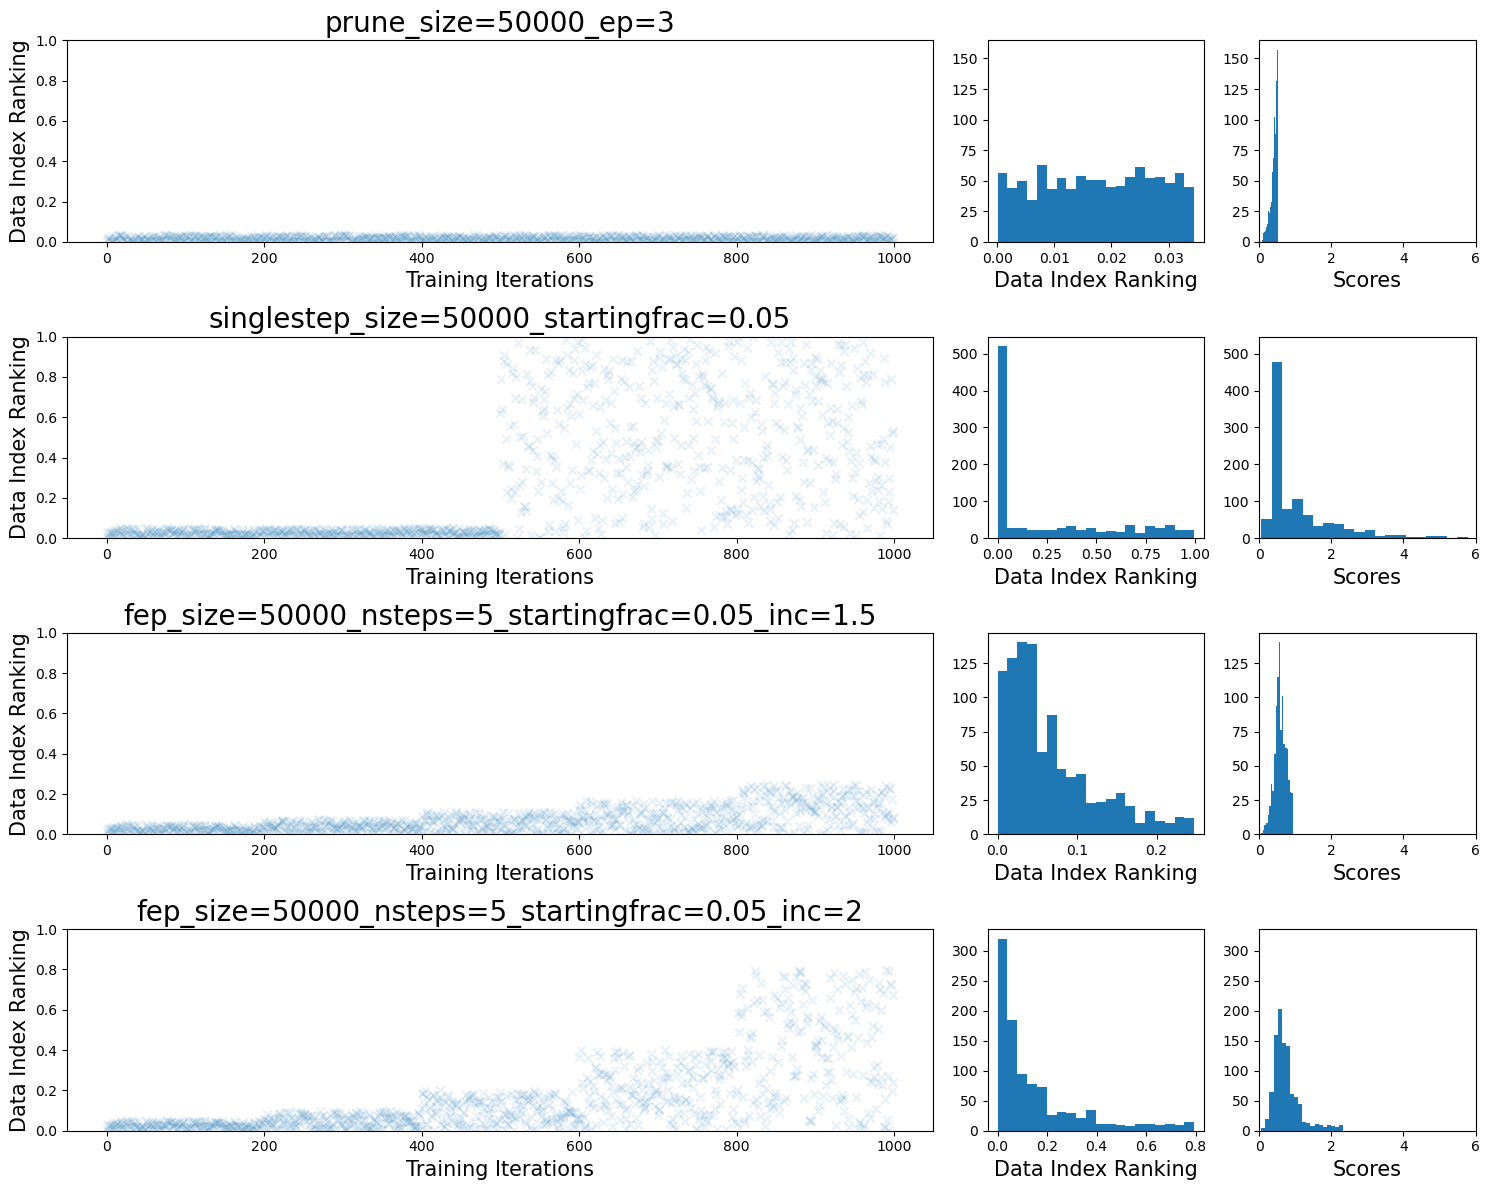

In [8]:
import re
import numpy as np
from note_curriculum import get_curriculum_scores, generate_curriculum, plt_curriculum
import glob
import matplotlib.pyplot as plt

model_name = 'mistral-7b'; dataset = 'ultrachat'; M =  50_000
# model_name = 'llama-7b'; dataset = 'tulu_v1_mix'; M = 150_000


paths = glob.glob('curriculum/*/*/*/scores.pkl')
paths = [x for x in paths if 'llama' in x and 'tulu_v1_mix' in x and 'log_prob_neg' in x]
path = paths[0]

verbose = True
print(path)
pacing_fn = f'prune_size={M}_ep=3'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.1'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.2'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.3'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=2'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.2_inc=1.5'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5'

pacing_fn_list = [
    f'prune_size={M}_ep=3',
    f'singlestep_size={M}_startingfrac=0.05',
#     f'singlestep_size={M}_startingfrac=0.1',
#     f'singlestep_size={M}_startingfrac=0.2',
#     f'singlestep_size={M}_startingfrac=0.3',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=2',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=3',
    f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.5',
    f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=2',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=3',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.25'
]



nrows = len(pacing_fn_list)
fig, axs = plt.subplots(nrows, 3, figsize=(15,3*nrows), sharey=False, gridspec_kw={'width_ratios': [2,.5,.5]})

for i, pacing_fn in enumerate(pacing_fn_list):

    plt_kwargs = generate_curriculum(path, pacing_fn, verbose=True, save_output=False)
    output = plt_kwargs.pop('output')
    plt_kwargs.update({'fig': fig, 'axs': axs[i]})
    plt_curriculum(**plt_kwargs)

fig.tight_layout()



save_plt = 0
if save_plt:
    model_name, dataset, scoring_fn = output['model_name'], output['dataset'], output['scoring_fn']
    save_path = os.path.join(
        assets_dir, f'note_curriculum_{model_name}:{dataset}:{scoring_fn}.png')
    fig.savefig(save_path, bbox_inches='tight', dpi=100)



### main code

In [11]:
import os
import sys
import numpy as np
import time
import re
import random
import pickle
from tqdm import tqdm 

import pyarrow
import torch
import transformers
import pandas as pd

from note_pruning import (
    save_to_pickle,
    save_sorted_inds,
    sort_kmeans_dist_to_cluster_centers,
    sort_dpp_map,
    save_prune_results,
    sort_dpp_map_memefficient,
)
from note_pruning_analysis import get_lm_output

In [21]:
test_run = False
dataset = 'tulu_v1_human_mix'
dataset = 'tulu_v2_human_mix'
dataset = 'flan_v2'
dataset = 'lima'
dataset = 'flan2022_1m'
dataset = 'tulu_v1_mix'
dataset = 'lima'
dataset = 'ultrachat'

# sort_by = 'random_s=0'
# sort_by = 'kmeansl2_nc=3000'
# sort_by = 'kmeanscd_nc=3000'
# sort_by = 'log_prob'
# sort_by = 'dppmap_k=Kcos'
# sort_by = 'dppmap_k=Kcos1np'
# sort_by = 'el2n'
# sort_by = 'grad_norm'
# sort_by = 'kmeansl2_emb=grad+rp+loraB_nc=3000'
# sort_by = 'kmeansl2_emb=text+embedding_nc=3000'
# sort_by = 'dppmap_emb=text+embedding_k=Kcos'
# sort_by = 'logit_margin'
# rhov1: mistral-7b base-tuned(ultrachat200k_beforesplitlongconv)
sort_by = 'rhov1'

# used for generating model output.
# model_name = 'llama-7b'
# model_name = 'llama-7b_ft=hmv1'
model_name = 'llama-7b+lora:r=256:a=256'
model_name = 'mistral-7b+lora:r=256:a=256'

# model_name = 'mistral-7b+lora:r=256:a=256__rho__mistral-7b-ultrachat200k-v1+lora:r=256:a=256'


save_dir = f"data_inds/"
save_dir = os.path.join(save_dir, model_name, dataset)
os.makedirs(save_dir, exist_ok=True)

print(dataset, model_name, sort_by)
print(save_dir)

ultrachat mistral-7b+lora:r=256:a=256 rhov1
data_inds/mistral-7b+lora:r=256:a=256/ultrachat


In [13]:
d = get_lm_output(dataset, model_name, return_text_embedding=True)
if test_run:
    d = {k: v[:1000] for k, v in d.items()}
    
# some entries are nan, impute with mean value.
N = d['text_embedding'].shape[0]
print(N)

219195


In [22]:
## the copy in `note_pruning.py` is most up to date

pkl_extra = {}
inds = None

t0 = time.time()
if any(sort_by.startswith(x) for x in [
        'log_prob', 
        'el2n',  # el2n_agg={l2n|mean}
        'logit_margin', 
        'grad',  # grad_{loraB|qkv|all|last}_l2n
    ]):
    if sort_by not in d:
        print(f'sort_by={sort_by} not in model output: ({dataset}, {model_name})')
    S = np.nan_to_num(d[sort_by], nan=np.nanmean(d[sort_by])).squeeze()
elif sort_by.startswith('random'):
    match = re.search(r's=(\d+)', sort_by)
    seed = int(match.group(1))
    np.random.seed(seed)
    S = np.random.rand(N)
    assert(S.shape == np.unique(S).shape)
if sort_by.startswith('kmeans'):
    dist_fn = 'l2' if sort_by.startswith('kmeansl2') else 'cd'
    match = re.search(r'nc=(\d+)', sort_by)
    n_clusters = int(match.group(1)) if match else None
    match = re.search(r'emb=([^_]+)', sort_by)
    embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
    if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
        raise ValueError(f'Invalid embed_type = {embed_type}')
    emb = d[embed_type]
    print(f'Running kmeans(n_clusters={n_clusters}) {{ {embed_type} }} to compute {"euclidean" if dist_fn == "l2" else "cosine"} distance to cluster centers.')
    S, kms = sort_kmeans_dist_to_cluster_centers(emb, n_clusters, dist_fn=dist_fn)
    pkl_extra['kmeans'] = kms
elif sort_by.startswith('dpp'):
    match = re.search(r'k=(\w+)', sort_by)
    kernel_type = match.group(1) if match else None
    match = re.search(r'emb=([^_]+)', sort_by)
    embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
    if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
        raise ValueError(f'Invalid embed_type = {embed_type}')
    emb = d[embed_type]
    inds = sort_dpp_map_memefficient(emb, log_prob, kernel_type=kernel_type, torch_compile=False)
elif sort_by.startswith('rho'):
    if sort_by == 'rhov1':
        model_names = ['mistral-7b+lora:r=256:a=256',
                       'mistral-7b-ultrachat200k-v1+lora:r=256:a=256']
        assert(model_name == model_names[0])
    else:
        raise ValueError(f'sort_by={sort_by} not implemented.')
    assert(len(model_names) == 2)
    ds = []
    for x in model_names:
        ds.append(get_lm_output(dataset, x, return_text_embedding=False, fill_nan=False))
    ks = [set(d.keys()) for d in ds]
    ks = ks[0] & ks[1]
    for k in ks:
        S0 = ds[0][k]
        S1 = ds[1][k]
        # handle nan entries properly.
        nan_mask = np.logical_or(np.isnan(S0), np.isnan(S1))
        S = np.subtract(S0, S1)
        S[nan_mask] = np.nan
        S = S.squeeze()
        save_prune_results(save_dir, None, S, {}, f'{sort_by}_{k}', model_name, dataset)
        

t1 = time.time()
print(f'Rank datapoints with {sort_by} took {t1-t0:.2f} seconds.')

# from note_pruning import save_prune_results
if not sort_by.startswith('rho'):
    save_prune_results(save_dir, inds, S, pkl_extra, sort_by, model_name, dataset)

save inds (length = 219195) to data_inds/mistral-7b+lora:r=256:a=256/ultrachat/rhov1_grad_loraB_l2n_incr.pkl
save inds (length = 219195) to data_inds/mistral-7b+lora:r=256:a=256/ultrachat/rhov1_grad_loraB_l2n_decr.pkl
save inds (length = 219195) to data_inds/mistral-7b+lora:r=256:a=256/ultrachat/rhov1_el2n_agg=l2n_incr.pkl
save inds (length = 219195) to data_inds/mistral-7b+lora:r=256:a=256/ultrachat/rhov1_el2n_agg=l2n_decr.pkl
save inds (length = 219195) to data_inds/mistral-7b+lora:r=256:a=256/ultrachat/rhov1_log_prob_incr.pkl
save inds (length = 219195) to data_inds/mistral-7b+lora:r=256:a=256/ultrachat/rhov1_log_prob_decr.pkl
save inds (length = 219195) to data_inds/mistral-7b+lora:r=256:a=256/ultrachat/rhov1_logit_margin_incr.pkl
save inds (length = 219195) to data_inds/mistral-7b+lora:r=256:a=256/ultrachat/rhov1_logit_margin_decr.pkl
save inds (length = 219195) to data_inds/mistral-7b+lora:r=256:a=256/ultrachat/rhov1_el2n_agg=mean_incr.pkl
save inds (length = 219195) to data_inds

('mistral-7b+lora:r=256:a=256', ['mistral-7b+lora:r=256:a=256'])

In [47]:
k = 'log_prob'
t = 100
S0 = ds[0][k].squeeze()[::t]
S1 = ds[1][k].squeeze()[::t]
# log prob neg
S0, S1 = -S0, -S1
# S = S0-S1

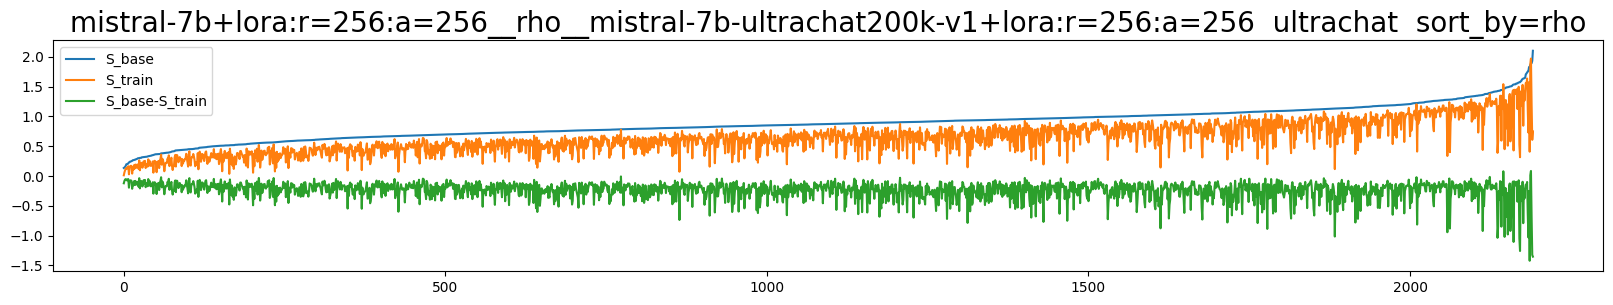

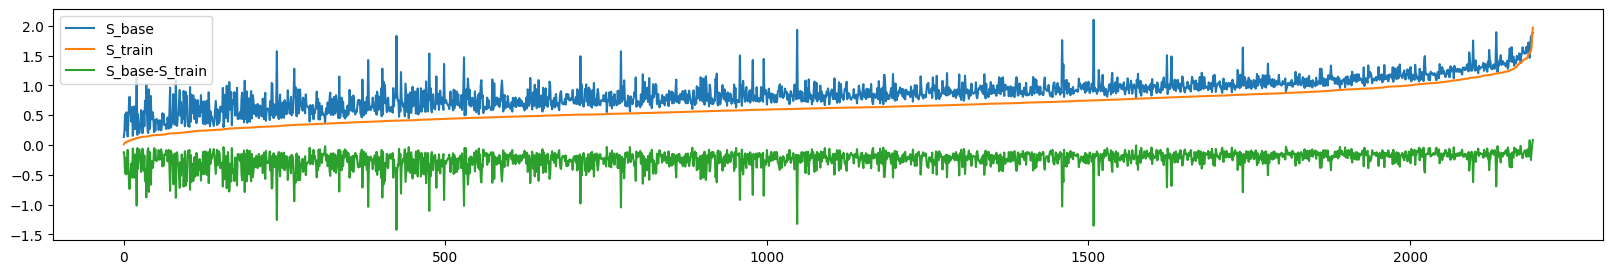

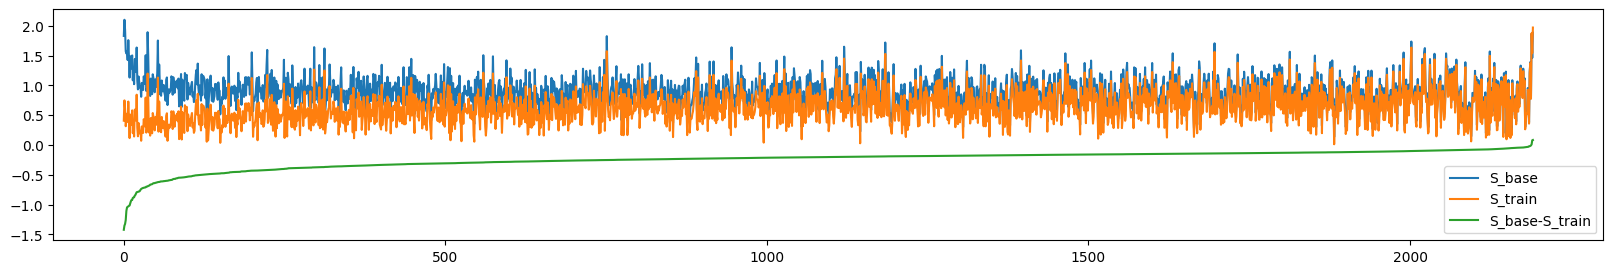

In [48]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(20, 3))
xs = np.arange(len(S0))
inds_sorted = np.argsort(S0)
ax.plot(xs, S0[inds_sorted], label='S_base')
ax.plot(xs, S1[inds_sorted], label='S_train')
ax.plot(xs, S[inds_sorted], label='S_base-S_train')
ax.legend()
ax.set_title(f'{model_name}  {dataset}  sort_by={sort_by}', fontsize=20)


fig, ax = plt.subplots(1,1,figsize=(20, 3))
xs = np.arange(len(S0))
inds_sorted = np.argsort(S1)
ax.plot(xs, S0[inds_sorted], label='S_base')
ax.plot(xs, S1[inds_sorted], label='S_train')
ax.plot(xs, S[inds_sorted], label='S_base-S_train')
ax.legend()


fig, ax = plt.subplots(1,1,figsize=(20, 3))
xs = np.arange(len(S0))
inds_sorted = np.argsort(S)
ax.plot(xs, S0[inds_sorted], label='S_base')
ax.plot(xs, S1[inds_sorted], label='S_train')
ax.plot(xs, S[inds_sorted], label='S_base-S_train')
ax.legend()


KeyboardInterrupt

